<a href="https://colab.research.google.com/github/immischein/ML-bandgap/blob/main/modeling_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Packages

In [1]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.6 MB/s eta 0:00:00


In [147]:
from google.colab import drive

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder

import category_encoders as ce

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm



### Load Datasets

In [121]:
drive.mount('/content/drive')

# load original dataset (all materials)
df_full = pd.read_csv('/content/drive/MyDrive/Project Documents ML-CMT/bandgap_dataset_full.csv')
# load balanced dataset (downsampled low bangap materials)
df_balanced= pd.read_csv('/content/drive/MyDrive/Project Documents ML-CMT/bandgap_dataset_balanced.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data cleaning step

In [122]:
def initial_data_cleaning(df, target_col='band_gap', id_col='material_id', corr_thresh=0.95):
    df = df.copy()

    # Drop identifier
    if id_col in df.columns:
        df = df.drop(columns=id_col)

    # Separate target
    X = df.drop(columns=target_col)
    y = df[target_col]

    # Split first (to avoid leakage)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Drop columns with >65% missing
    missing_frac = X_train.isnull().mean()
    drop_cols = missing_frac[missing_frac > 0.65].index.tolist()
    print(f"Dropping columns with >65% missing values: {drop_cols}")
    X_train = X_train.drop(columns=drop_cols)
    X_test = X_test.drop(columns=drop_cols)

    # Correlation-based feature dropping (on train set only)
    corr_matrix = X_train.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = []
    for col in upper.columns:
        for row in upper.index:
            if upper.loc[row, col] > corr_thresh:
                if row in to_drop or col in to_drop:
                    continue
                target_corr = X_train.corrwith(y_train)
                drop = row if target_corr[row] < target_corr[col] else col
                to_drop.append(drop)

    print(f"Dropping correlated features: {to_drop}")
    X_train = X_train.drop(columns=to_drop)
    X_test = X_test.drop(columns=to_drop)

    return X_train, X_test, y_train, y_test

### Preprocessing Pipeline

In [123]:
class TargetEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column  # ✅ declared here, not in fit
        self.encoder_ = None  # ✅ trailing underscore: fitted object

    def fit(self, X, y):
        self.encoder_ = ce.TargetEncoder(cols=[self.column])
        self.encoder_.fit(X, y)
        return self

    def transform(self, X):
        return self.encoder_.transform(X)


In [124]:
def build_preprocessor(numeric_cols, nonnumeric_cols, te_col='spacegroup_number '):
    if te_col in numeric_cols:
        numeric_cols = [col for col in numeric_cols if col != te_col]

    num_pipeline = make_pipeline(
        SimpleImputer(strategy='mean'),
        StandardScaler()
    )

    # cat_pipeline = make_pipeline(TargetEncoderWrapper())
    cat_pipeline = make_pipeline(TargetEncoderWrapper(column='spacegroup_number '))

    nonnumeric_pipeline = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(handle_unknown="ignore")
    )

    preprocessor = make_column_transformer(
        (num_pipeline, numeric_cols),
        (cat_pipeline, [te_col]),
        (nonnumeric_pipeline, nonnumeric_cols)
    )

    return preprocessor


### CV Training Pipeline

In [125]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def run_pipeline_with_cv(X, y, model_dict, cv=5):
    results = []

    te_col = 'spacegroup_number '
    numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
    nonnumeric_cols = X.select_dtypes(exclude=np.number).columns.tolist()
    if te_col in numeric_cols:
        numeric_cols.remove(te_col)

    for name, model in model_dict.items():
        print(f"\nRunning CV for model: {name}")

        # Build a fresh pipeline for each model
        pipeline = make_pipeline(
            build_preprocessor(numeric_cols, nonnumeric_cols, te_col=te_col),
            model
        )

        scores = cross_validate(
            pipeline, X, y, cv=cv,
            scoring={
                'mae': 'neg_mean_absolute_error',
                'r2': 'r2',
                'rmse': make_scorer(rmse, greater_is_better=False)
            },
            return_train_score=False
        )

        results.append({
            'Model': name,
            'MAE (mean)': -np.mean(scores['test_mae']),
            'RMSE (mean)': -np.mean(scores['test_rmse']),
            'R² (mean)': np.mean(scores['test_r2'])
        })

    return pd.DataFrame(results)

### Evaluation Pipeline

In [126]:
def run_final_test_evaluation(X_train, X_test, y_train, y_test, model_dict):
    final_results = []
    trained_pipelines = []

    # Detect column types
    te_col = 'spacegroup_number '
    numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
    nonnumeric_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

    # Remove target-encoded column from numeric
    if te_col in numeric_cols:
        numeric_cols.remove(te_col)

    for name, model in model_dict.items():
        print(f"\nTraining final model: {name}")

        # Build preprocessor and pipeline
        preprocessor = build_preprocessor(numeric_cols, nonnumeric_cols, te_col=te_col)
        pipeline = make_pipeline(preprocessor, model)

        # Fit on full training set
        pipeline.fit(X_train, y_train)

        # Evaluate on test set
        y_pred = pipeline.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        rmse_ = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        final_results.append({
            'Model': name,
            'Test MAE': mae,
            'Test RMSE': rmse_,
            'Test R²': r2
        })

        trained_pipelines.append((name, pipeline))

    return pd.DataFrame(final_results), dict(trained_pipelines)


### Neural Network training

In [144]:
class BandgapNet(nn.Module):
    def __init__(self, input_dim):
        super(BandgapNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


In [148]:
def train_torch_model(X_train, X_test, y_train, y_test, num_epochs=100, batch_size=64, lr=1e-3, print_every=10):
    te_col = 'spacegroup_number '
    numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
    nonnumeric_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

    if te_col in numeric_cols:
        numeric_cols.remove(te_col)

    # Step 1: Preprocess
    preprocessor = build_preprocessor(numeric_cols, nonnumeric_cols, te_col)
    X_train_proc = preprocessor.fit_transform(X_train, y_train)
    X_test_proc = preprocessor.transform(X_test)

    # Step 2: Convert to tensors
    X_train_tensor = torch.tensor(X_train_proc.astype(np.float32))
    y_train_tensor = torch.tensor(y_train.values.astype(np.float32)).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test_proc.astype(np.float32))
    y_test_tensor = torch.tensor(y_test.values.astype(np.float32)).unsqueeze(1)

    # Step 3: Create dataset and dataloader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Step 4: Initialize model, loss, optimizer
    model = BandgapNet(input_dim=X_train_tensor.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    # Step 5: Train loop with tqdm
    for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
        model.train()
        epoch_train_loss = 0.0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * X_batch.size(0)

        avg_train_loss = epoch_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_pred = model(X_test_tensor)
            val_loss = criterion(val_pred, y_test_tensor).item()
            val_losses.append(val_loss)

        # Optional print
        if (epoch + 1) % print_every == 0 or epoch == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch+1:3d} | Train Loss: {avg_train_loss:.5f} | Val Loss: {val_loss:.5f}")

    # Step 6: Final Evaluation
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).squeeze().numpy()
        y_true = y_test_tensor.squeeze().numpy()

    mae = mean_absolute_error(y_true, y_pred)
    rmse_ = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # Step 7: Plot learning curves
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('PyTorch Neural Network Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'Model': 'PyTorch DNN',
        'Test MAE': mae,
        'Test RMSE': rmse_,
        'Test R²': r2
    }, model, preprocessor

## Models

In [135]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "MLP": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, early_stopping=True, random_state=42)
}

# Modeling Experiment 1: What is the influence of downsampling the low bandgap data?

#### Full dataset

In [136]:
# Clean data
X_train_full, X_test_full, y_train_full, y_test_full = initial_data_cleaning(df_full, target_col='band_gap')

Dropping columns with >65% missing values: []
Dropping correlated features: ['mean_distance', 'std_distance', 'std_am_weighted', 'std_vdw_weighted', 'std_molar_volume_weighted', 'electron_affinity_range_weighted', 'en_range', 'max_en ', 'avg_en', 'std_en', 'ie_range', 'max_ie ', 'min_ie', 'avg_am', 'am_range', 'max_am ', 'vdw_range', 'avg_vdw', 'max_vdw ', 'min_vdw', 'std_molar_volume', 'max_molar_volume ', 'electron_affinity_range', 'std_electron_affinity', 'avg_electronegativity', 'electronegativity_range', 'std_electronegativity', 'max_electronegativity ', 'min_electronegativity', 'atomic_radius_range', 'max_atomic_radius ', 'boiling_point_range', 'avg_boiling_point', 'max_boiling_point ']


In [137]:
# CV training using full training set
cv_results_full = run_pipeline_with_cv(X_train_full, y_train_full, models, cv=5)
display(cv_results_full)


Running CV for model: Linear Regression

Running CV for model: Random Forest

Running CV for model: MLP


,Model,MAE (mean),RMSE (mean),R² (mean)
0,Linear Regression,1.042909,1.310815,0.289514
1,Random Forest,0.666381,0.935851,0.637800
2,MLP,0.797147,1.062212,0.533421


In [138]:
# Train on full train set, evaluate on test
test_results_full, trained_models = run_final_test_evaluation(X_train_full, X_test_full, y_train_full, y_test_full, models)
display(test_results_full)


Training final model: Linear Regression

Training final model: Random Forest

Training final model: MLP


,Model,Test MAE,Test RMSE,Test R²
0,Linear Regression,1.042296,1.312468,0.286370
1,Random Forest,0.636155,0.897099,0.666592
2,MLP,0.772779,1.034674,0.556491


Training Epochs:   1%|          | 1/100 [00:01<02:53,  1.76s/it]

Epoch   1 | Train Loss: 1.66942 | Val Loss: 1.45437


Training Epochs:  10%|█         | 10/100 [00:20<03:21,  2.24s/it]

Epoch  10 | Train Loss: 1.09162 | Val Loss: 1.12217


Training Epochs:  20%|██        | 20/100 [00:38<02:29,  1.87s/it]

Epoch  20 | Train Loss: 0.97179 | Val Loss: 1.05134


Training Epochs:  30%|███       | 30/100 [00:57<02:09,  1.84s/it]

Epoch  30 | Train Loss: 0.89275 | Val Loss: 1.05286


Training Epochs:  40%|████      | 40/100 [01:17<01:55,  1.92s/it]

Epoch  40 | Train Loss: 0.84382 | Val Loss: 1.03762


Training Epochs:  50%|█████     | 50/100 [01:35<01:31,  1.83s/it]

Epoch  50 | Train Loss: 0.80055 | Val Loss: 1.02696


Training Epochs:  60%|██████    | 60/100 [01:56<01:24,  2.10s/it]

Epoch  60 | Train Loss: 0.77204 | Val Loss: 1.02856


Training Epochs:  70%|███████   | 70/100 [02:15<00:55,  1.86s/it]

Epoch  70 | Train Loss: 0.75075 | Val Loss: 1.02458


Training Epochs:  80%|████████  | 80/100 [02:34<00:40,  2.01s/it]

Epoch  80 | Train Loss: 0.73076 | Val Loss: 1.01431


Training Epochs:  90%|█████████ | 90/100 [02:53<00:19,  1.90s/it]

Epoch  90 | Train Loss: 0.70696 | Val Loss: 1.02870


Training Epochs: 100%|██████████| 100/100 [03:13<00:00,  1.93s/it]

Epoch 100 | Train Loss: 0.69453 | Val Loss: 1.01237


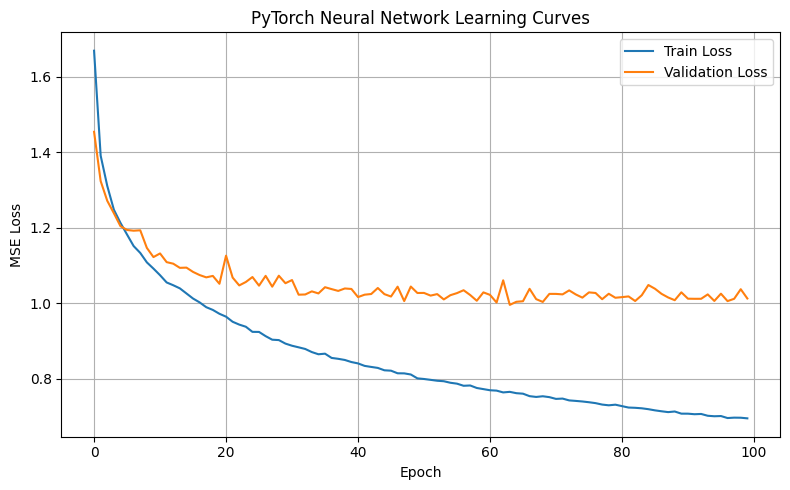

,Model,Test MAE,Test RMSE,Test R²
0,PyTorch DNN,0.746028,1.006164,0.580595


In [149]:
torch_result_full, torch_model_full, torch_preprocessor_full = train_torch_model(
    X_train_full, X_test_full, y_train_full, y_test_full,
    num_epochs=100, lr=1e-3, batch_size=64, print_every=10
)

display(pd.DataFrame([torch_result_full]))

#### Balanced dataset

In [139]:
# Clean data
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = initial_data_cleaning(df_balanced, target_col='band_gap')

Dropping columns with >65% missing values: []
Dropping correlated features: ['mean_distance', 'std_distance', 'std_am_weighted', 'std_vdw_weighted', 'std_molar_volume_weighted', 'electron_affinity_range_weighted', 'en_range', 'max_en ', 'avg_en', 'std_en', 'ie_range', 'max_ie ', 'min_ie', 'avg_am', 'am_range', 'max_am ', 'vdw_range', 'avg_vdw', 'max_vdw ', 'min_vdw', 'std_molar_volume', 'max_molar_volume ', 'electron_affinity_range', 'std_electron_affinity', 'avg_electronegativity', 'electronegativity_range', 'std_electronegativity', 'max_electronegativity ', 'min_electronegativity', 'atomic_radius_range', 'max_atomic_radius ', 'avg_boiling_point', 'boiling_point_range', 'max_boiling_point ']


In [140]:
# For CV we use full training set
cv_results_balanced = run_pipeline_with_cv(X_train_balanced, y_train_balanced, models, cv=5)
display(cv_results_balanced)


Running CV for model: Linear Regression

Running CV for model: Random Forest

Running CV for model: MLP


,Model,MAE (mean),RMSE (mean),R² (mean)
0,Linear Regression,1.024386,1.293052,0.309979
1,Random Forest,0.660474,0.925348,0.646537
2,MLP,0.781334,1.039648,0.553800


In [141]:
# Train on full train set, evaluate on test
test_results_balanced, trained_models = run_final_test_evaluation(X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced, models)
display(test_results_balanced)


Training final model: Linear Regression

Training final model: Random Forest

Training final model: MLP


,Model,Test MAE,Test RMSE,Test R²
0,Linear Regression,1.022686,1.285546,0.306373
1,Random Forest,0.635946,0.894006,0.664547
2,MLP,0.767046,1.020341,0.563040


Training Epochs:   1%|          | 1/100 [00:01<02:11,  1.33s/it]

Epoch   1 | Train Loss: 1.72931 | Val Loss: 1.46983


Training Epochs:  10%|█         | 10/100 [00:14<02:13,  1.48s/it]

Epoch  10 | Train Loss: 1.06771 | Val Loss: 1.14256


Training Epochs:  20%|██        | 20/100 [00:29<01:55,  1.45s/it]

Epoch  20 | Train Loss: 0.94137 | Val Loss: 1.03915


Training Epochs:  30%|███       | 30/100 [00:43<01:40,  1.43s/it]

Epoch  30 | Train Loss: 0.86134 | Val Loss: 1.00746


Training Epochs:  40%|████      | 40/100 [00:59<01:33,  1.56s/it]

Epoch  40 | Train Loss: 0.80723 | Val Loss: 0.98577


Training Epochs:  50%|█████     | 50/100 [01:13<01:08,  1.37s/it]

Epoch  50 | Train Loss: 0.75998 | Val Loss: 0.97624


Training Epochs:  60%|██████    | 60/100 [01:28<00:58,  1.47s/it]

Epoch  60 | Train Loss: 0.72055 | Val Loss: 0.99097


Training Epochs:  70%|███████   | 70/100 [01:44<00:45,  1.51s/it]

Epoch  70 | Train Loss: 0.69666 | Val Loss: 1.01284


Training Epochs:  80%|████████  | 80/100 [01:59<00:31,  1.57s/it]

Epoch  80 | Train Loss: 0.67213 | Val Loss: 0.98701


Training Epochs:  90%|█████████ | 90/100 [02:14<00:16,  1.62s/it]

Epoch  90 | Train Loss: 0.65484 | Val Loss: 1.00229


Training Epochs: 100%|██████████| 100/100 [02:29<00:00,  1.49s/it]

Epoch 100 | Train Loss: 0.63370 | Val Loss: 1.00814


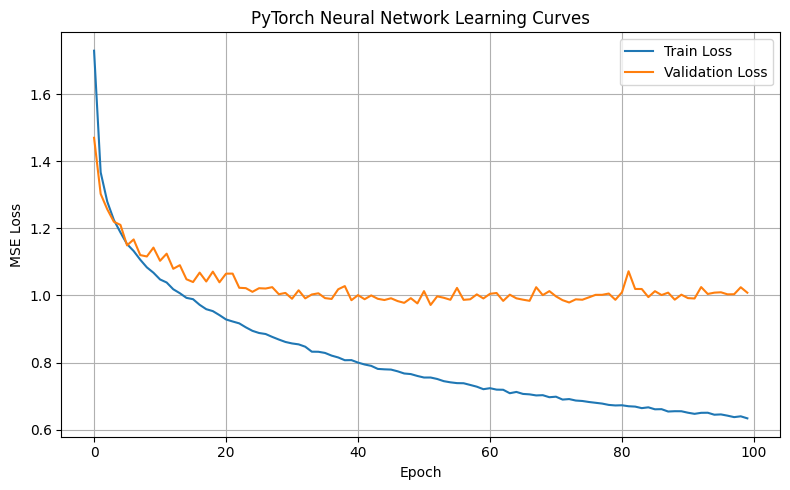

,Model,Test MAE,Test RMSE,Test R²
0,PyTorch DNN,0.737275,1.004064,0.576871


In [150]:
torch_result_balanced, torch_model_balanced, torch_preprocessor_balanced= train_torch_model(
    X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced,
    num_epochs=100, lr=1e-3, batch_size=64, print_every=10
)

display(pd.DataFrame([torch_result_balanced]))

#### Result

In [154]:
# turn results to dataframe
df_torch_full = pd.DataFrame([torch_result_full])
df_torch_balanced = pd.DataFrame([torch_result_balanced])

# Add column to indicate dataset
test_results_full['Dataset'] = 'Full'
df_torch_full['Dataset'] = 'Full'
test_results_balanced['Dataset'] = 'Balanced'
df_torch_balanced['Dataset'] = 'Balanced'

combined_results = pd.concat([
    test_results_full,
    df_torch_full,
    test_results_balanced,
    df_torch_balanced
], ignore_index=True)

combined_results = combined_results[['Model', 'Dataset', 'Test MAE', 'Test RMSE', 'Test R²']]

display(combined_results.sort_values(by=['Model', 'Dataset']))

,Model,Dataset,Test MAE,Test RMSE,Test R²
4,Linear Regression,Balanced,1.022686,1.285546,0.306373
0,Linear Regression,Full,1.042296,1.312468,0.286370
6,MLP,Balanced,0.767046,1.020341,0.563040
2,MLP,Full,0.772779,1.034674,0.556491
7,PyTorch DNN,Balanced,0.737275,1.004064,0.576871
3,PyTorch DNN,Full,0.746028,1.006164,0.580595
5,Random Forest,Balanced,0.635946,0.894006,0.664547
1,Random Forest,Full,0.636155,0.897099,0.666592


**Conclusion**: Downsampling the materials with a low value for the bandgap (keeping only 50% of the materials with a bandgap in the region 0 to 1.75 meV) doesn't have a big influence on the model performance.
**Decision**: Keep the full dataset to have more samples (useful for deep networks).